## Combining Pat's RAMP simulator with noise generator 

Started April 20th <br>
Last edited May 19th

The RAMP simulator is per pixel now, should change to image by adding to noise generator (read noise, shot noise, 1/f (pink) noise) data cube and loop over reads. The noise generator takes longer for generating all the reads ...


In [2]:
from make_random_trace import make_random_trace
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

import nghxrg as ng

In [21]:
def sumRange(L,a,b,printslopes):                                                                                                                                                                                                
    s = 0                                                                                                                                                                                                         
    for i in range(a,b):  
        if printslopes:
            if i == a:
                print('Group slopes:')
            print(i, ' ', L[i] - L[i-1])
        s += pow((L[i] - L[i-1]) + b,2)  
    return s 

def make_random_trace(nelem=2e4, k=1., plots=1):
    ''' make a binary random trace in (-1,1) with exponentially distributed dwell 
    times. nelem = number of jumps. k = rate.'''
    k = float(k)
    dt = 1./k
    rg = np.random.rand( np.int(nelem) )
    ra = np.abs(rg)
    ra = ra/np.max(ra)
    # exponentially distributed jumps:
    t = np.log(1/ra)/k
    tr = np.floor(t/dt)
    # print('max trace ',np.max(tr))
    x = []
    s = 3.0e-3
    # do it:
    for j in np.arange(len(tr)):
        for ti in np.arange(np.int(tr[j])):
            x = np.append(x, s*np.ones(ti))
            s = -s
    time = np.arange(len(x))*dt
    spectrum_x = np.abs(np.fft.fft(x))**2
    freq_x = np.fft.fftfreq(len(x), d=dt)
    freq_x = freq_x[:int(len(spectrum_x)/2.)]
    spectrum_x = spectrum_x[:len(freq_x)]
    spectrum_x = spectrum_x/float(len(x)**2 *freq_x[1])
    spectrum_x[1:] = 2*spectrum_x[1:]

    if plots:
        plt.subplot(211)
        plt.plot(time[:], x[:], '-o')
        plt.subplot(212)
        plt.loglog(freq_x, spectrum_x, '.')
        plt.show()

    return x, time

def RTN(RTN_num, nreads, fdarkN, nelements=2000,rate=0.2):
    
    ru = np.random.uniform
    
    tf = 1.4548 # tf = 1.42 in DPU test Sec. 8.2.
    tread = np.arange(nreads)*tf
    
    if RTN_num==0:
        fdarkN = fdarkN
        
    if RTN_num==1: 
        sRTN, tRTN = make_random_trace(nelements,rate,0)  
        sRTNterp = ru(200)*np.interp(tread,tRTN,sRTN)
        fon = ru(0.0)
        if (fon < 0.5):
            fon = 0.5    #  At least 50%
        for RTN in range(0,nreads):
            on = ru(0.0)
            if (on <= fon):
                fdarkN[RTN] += sRTNterp[RTN]*np.mean(fdarkN)

    if RTN_num==2:
        fon = ru(0.0) # frequency of readouts that should have RTN
        if (fon < 0.2):  
            fon = 0.2    #  At least 20%.
        level = 0.2*np.mean(fdarkN) # RTN maximum offset from nominal
        level = level*ru(0.0)
        for RTN in range(0,nreads):
            # Generate a random number to decide if this readout is telegraphing 
            # or not.
            on = ru(0.0) 
            if (on <= fon):
                fdarkN[RTN] += level
                
    if RTN_num==3:
        sRTN, tRTN = make_random_trace(nelements,rate,0)
        sRTNterp = np.interp(tread,tRTN,sRTN)
        onoff = np.round(ru( np.float(nreads) ))
        fdarkN = fdarkN + sRTNterp*0.15*np.mean(fdarkN)*onoff

    return fdarkN
    
def MACCsimulator(darkcurrent=0.04, nonlin=-0.00005, readnoise =9.0, RTN_num=1, rtn_nelements=2000, rtn_rate=0.2 , plot='yes'):
    '''MACC simulator with different parameters'''
    
    lightcurrent=10.0
    ng=15
    nf=16
    nd=11
    tf = 1.4548 # tf = 1.42 in DPU test Sec. 8.2.
    detGain = 1.3 # detGain = 1/1.4 DPU test; typos "8.4"?
    offsetADU = 0.
    
    sigmaRead = readnoise/detGain # ADU
    fluence = ( darkcurrent + lightcurrent )/ detGain  # ADU/sec
    tgrp = (nf + nd)*tf
    tint = (ng-1.)*(nf+nd)*tf
    nreads = int((ng*nf + (ng-1.)*nd))
    texp =  nreads*tf

    # time vector
    read = np.arange(nreads)
    tread = read*tf
    fdark = fluence*tread + nonlin*((fluence*tread)**2) #  curved signal
    if plot=='yes':
        plt.plot(tread,fdark,label='dark')

    rg = np.random.rand(nreads)            
    fdarkN = fdark + rg * sigmaRead  / np.max(rg)  

    if plot=='yes':
        plt.plot(tread,fdarkN,label='+random noise')

    ## ADDRTN    
    fdarkN = RTN(RTN_num,nreads,fdarkN ,nelements=rtn_nelements, rate=rtn_rate)
        
    alpha = (1 - (nf**2))/(3.*nf*(nf+nd))  
    beta = 2.*(sigmaRead**2)/(nf*(alpha+1))   
    s2,t2 = np.float(), np.float()
    for i in range(nreads):
        if i % int(nf+nd) in (range(nf)):
            s = fdarkN[i]
            t = tread[i]
            s2 = np.append(s2, s)
            t2 = np.append(t2, t) 
    
    if plot=='yes':
        plt.plot(t2,s2,'r.',label='groups')

    fgrp = np.reshape(s2[1:],[ng,nf])
    tgrp = np.reshape(t2[1:],[ng,nf])
    fgrpavg,tgrpavg =[],[]
    for i in range(ng):
        fga = np.mean(fgrp[i,:])
        tga = np.mean(tgrp[i,:])
        fgrpavg = np.append(fgrpavg, fga)
        tgrpavg = np.append(tgrpavg, tga)

    if plot=='yes':
        plt.plot(tgrpavg,fgrpavg,'g.',label='avg')
        plt.legend(loc=4)


    L = fgrpavg   
    deltaT = tgrpavg[1]-tgrpavg[0] 
    a = 1
    b = ng

    slopeDPU_1 = np.sqrt( 1 + 4 * ( sumRange(L,a,b,0)/((ng - 1)*((1+alpha)**2)) ) )  # DPU Manual
    slopeDPU_0 = (1 + alpha) / 2.  # DPU manual
    slopeDPU = slopeDPU_0 * (slopeDPU_1 - 1) - beta
    signalDPU = slopeDPU * (ng - 1) + offsetADU # Downlinked signal in ADU
    pseudoFlux = np.sqrt ( sumRange(L,a,b,0) / (ng - 1) ) - beta
    QF = ( 2*detGain/(1+alpha) ) * ( (ng - 1)*pseudoFlux - (fgrpavg[ng-1] - fgrpavg[0]) )

    # Simple least squares fit to the full ramp for comparison
    coeff = poly.polyfit(tread[1:], fdarkN[1:], 1)
    ffit = poly.polyval(tread[1:], coeff)
    chisqr = np.sum((poly.polyval(tread, coeff) - fdarkN) ** 2) / np.std(fdarkN)

    return QF,signalDPU

(2315.0487926146347, 4041.77239544685)

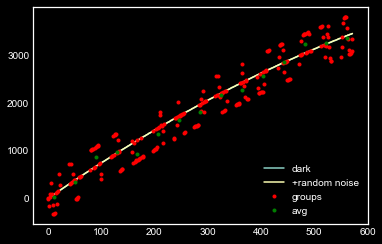

In [42]:
MACCsimulator(darkcurrent=0.04, nonlin=-0.00005, readnoise =9.0, RTN_num=1, rtn_nelements=500, rtn_rate=0.2 , plot='yes')

### With no non-linearity and RTN what is the fluctuation in Signal DPU and quality flag?

In [5]:
a=[]
for i in range(4000):
    a.append(MACCsimulator(darkcurrent=0.04, nonlin=0, readnoise =9.0, RTN_num=0, rtn_nelements=2000, rtn_rate=0.2 , plot='no'))
    

Text(0.5, 0, 'Quality Flag')

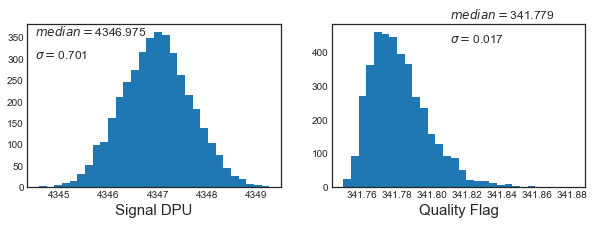

In [6]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
h = plt.hist((np.transpose(a)[1]),bins=30)
plt.text(4344.5,355,'$ median =$'+str(np.round(np.median(np.transpose(a)[1]),3)),fontsize=12)
plt.text(4344.5,300,'$\sigma =$'+str(np.round(np.std(np.transpose(a)[1]),3)),fontsize=12)
plt.xlabel('Signal DPU',size=15)

plt.subplot(1,2,2)
h = plt.hist((np.transpose(a)[0]),bins=30)
plt.text(341.81,500,'$ median =$'+str(np.round(np.median(np.transpose(a)[0]),3)),fontsize=12)
plt.text(341.81,430,'$\sigma =$'+str(np.round(np.std(np.transpose(a)[0]),3)),fontsize=12)

plt.xlabel('Quality Flag',size=15)


## How the median and sigma change with adding non-linearity (still no RTN):

In [7]:
nl, med_signal, med_quality, std_signal, std_quality = [],[],[],[],[]
for j in range(10):
    a=[]
    for i in range(1000):
        a.append(MACCsimulator(darkcurrent=0.04, nonlin=-j*0.00001, readnoise =9.0, RTN_num=0, rtn_nelements=2000, rtn_rate=0.2 , plot='no'))
    nl.append(-j*0.00001)
    med_signal.append(np.median(np.transpose(a)[1]))
    med_quality.append(np.median(np.transpose(a)[0]))
    std_signal.append(np.std(np.transpose(a)[1]))
    std_quality.append(np.std(np.transpose(a)[0]))
    

Text(0.5, 0, 'Non linearity')

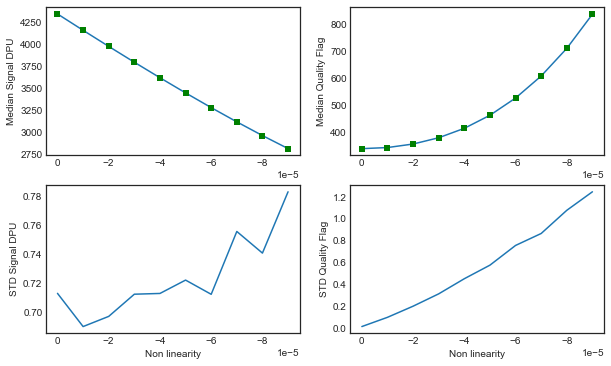

In [8]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.errorbar(nl,med_signal,yerr=std_signal,marker='s', mfc='red',mec='green', ms=2, mew=4)
plt.gca().invert_xaxis()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Median Signal DPU')

plt.subplot(2,2,2)
plt.errorbar(nl,med_quality,yerr=std_quality,marker='s', mfc='red',mec='green', ms=2, mew=4)
plt.gca().invert_xaxis()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('Median Quality Flag')

plt.subplot(2,2,3)
plt.plot(nl,std_signal)
plt.gca().invert_xaxis()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('STD Signal DPU')
plt.xlabel('Non linearity')

plt.subplot(2,2,4)
plt.errorbar(nl,std_quality)
plt.gca().invert_xaxis()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel('STD Quality Flag')
plt.xlabel('Non linearity')


### MCMC over non-linearity and different types of RTN

In [9]:
def mcmc_nonlinearity(steps=1500):
    '''MCMC over non_linearity and RTNs to see effect on QF'''
    
    noise = 9.0
    dark = 0.04

    nl0 = -0.00005
    rtn0 = 0
    rtn_nelements0 = 2000
    rtn_rate0 = 0.2
    
    p0,s0 = MACCsimulator(darkcurrent=dark, nonlin=nl0, readnoise =noise, RTN_num=rtn0, rtn_nelements=rtn_nelements0, rtn_rate=rtn_rate0 , plot='no')

    chain=[[nl0,rtn0,rtn_nelements0,rtn_rate0,p0,s0]]
    x=[0]
    for i in range(steps):
    
        index=1#np.random.randint(1,2)
    
        nl1, rtn1, rtn_nelements1, rtn_rate1 = nl0, rtn0, rtn_nelements0, rtn_rate0
    
        nl1 = -0.00015*np.random.uniform(0,1)
        #if index==1:
        #    nl1 = nl0 + 0.00001*(np.random.uniform(-1,1))
        #    if (nl1 >= 0.0):
        #        nl1 = nl0 + 0.00001*(np.random.uniform(-1,0))
               
        rtn1 = np.random.randint(1,5)-1
        if rtn1 ==0:
            rtn_nelements1,rtn_rate1 = rtn_nelements0,rtn_rate0
        else:
            rtn_nelements1 = rtn_nelements0+50.0*(np.random.uniform(-1,1))
            rtn_rate1 = rtn_rate0+0.01*(np.random.uniform(-1,1))
            if rtn_rate1 <0:
                rtn_rate1 = rtn_rate0+0.01*(np.random.uniform(0,1))


  
        p0,s0 = MACCsimulator(darkcurrent=dark, nonlin=nl0, readnoise =noise, RTN_num=rtn0, rtn_nelements=rtn_nelements0, rtn_rate=rtn_rate0 , plot='no')
        p1,s1 = MACCsimulator(darkcurrent=dark, nonlin=nl1, readnoise =noise, RTN_num=rtn1, rtn_nelements=rtn_nelements1, rtn_rate=rtn_rate1 , plot='no')
        
        if i%1000==0:
            print(i)    
    
        if (np.abs(p0-p1) < 1000):
            x.append(i)
            chain.append([nl1,rtn1,rtn_nelements1,rtn_rate1,p1,s1])
            nl0, rtn0, rtn_nelements0, rtn_rate0  = nl1, rtn1, rtn_nelements1, rtn_rate1

    nevis = open('MAAC_params'+str(steps)+'.cat', 'w')
    for i in range(len(chain)):
        nevis.write(str(chain[i][0])+'\t'+str(chain[i][1])+'\t'+str(chain[i][2])+'\t'\
                    +str(chain[i][3])+'\t'+str(chain[i][4])+'\t'+str(chain[i][5])+'\n')
    nevis.close()   
    
    return chain

In [10]:
chain = mcmc_nonlinearity(10000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


5594


Text(0.5, 0, 'RTN nelements')

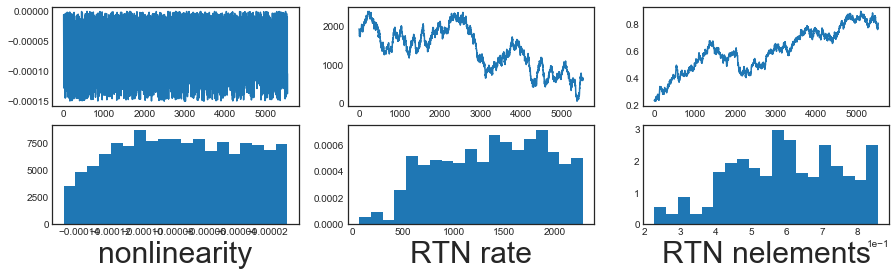

In [11]:
burnin=int(0.01*len(chain))
print(len(chain))
k=0
nevis=np.loadtxt('MAAC_params10000.cat')
falp,fbet,flst,x2=np.zeros(len(nevis[:,0])-burnin),np.zeros(len(nevis[:,0])-burnin),np.zeros(len(nevis[:,0])-burnin),np.zeros(len(nevis[:,0])-burnin)

for i in range(burnin,len(nevis[:,0])):
    falp[k]=nevis[i][0]
    fbet[k]=nevis[i][2]
    flst[k]=nevis[i][3]
    x2[k]=k
    k+=1

f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3)
f.set_figheight(4)
f.set_figwidth(15)

ax1.plot(x2,falp)
ax2.plot(x2,fbet)
ax3.plot(x2,flst)

binwidth=(max(falp)-min(falp))/20
binso=np.arange(min(falp), max(falp), binwidth)
hehe=ax4.hist(falp,bins=binso,normed=1)
xhist=hehe[1][0:-1]+binwidth/2.0
yhist=hehe[0]
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax4.set_xlabel(r'nonlinearity',size=30)

binwidth=(max(fbet)-min(fbet))/20
binso=np.arange(min(fbet), max(fbet), binwidth)
haha=ax5.hist(fbet,bins=binso,normed=1)
xhist=haha[1][0:-1]+binwidth/2.0
yhist=haha[0]
ax5.set_xlabel(r'RTN rate',size=30)

binwidth=(max(flst)-min(flst))/20
binso=np.arange(min(flst), max(flst), binwidth)
hoho=ax6.hist(flst,bins=binso,normed=1)
xhist=hoho[1][0:-1]+binwidth/2.0
yhist=hoho[0]
ax6.set_xlabel(r'RTN nelements',size=30)


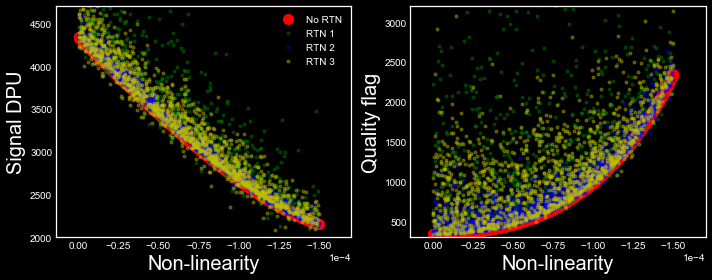

In [12]:
ch = np.transpose(chain)
plt.style.use('dark_background')

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

u = (ch[1]==0)
plt.plot(ch[0][u],ch[5][u], 'r.',markersize=20,label='No RTN')

u1 = (ch[1]==1)
plt.plot(ch[0][u1],ch[5][u1], 'g.',alpha=0.4,label='RTN 1')

u2 = (ch[1]==2)
plt.plot(ch[0][u2],ch[5][u2], 'b.',alpha=0.4,label='RTN 2')

u3 = (ch[1]==3)
plt.plot(ch[0][u3],ch[5][u3], 'y.',alpha=0.4,label='RTN 3')


plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.ylabel('Signal DPU',size=20)
plt.xlabel('Non-linearity',size=20)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.gca().invert_xaxis()
plt.legend(loc=1,fontsize=10)

plt.subplot(1,2,2)
plt.plot(ch[0][u],ch[4][u], 'r.',markersize=20,label='No RTN')
plt.plot(ch[0][u1],ch[4][u1], 'g.',alpha=0.4,label='RTN 1')
plt.plot(ch[0][u2],ch[4][u2], 'b.',alpha=0.4,label='RTN 2')
plt.plot(ch[0][u3],ch[4][u3], 'y.',alpha=0.4,label='RTN 3')

plt.xlim([-0.00017,0.000014])
plt.ylim([300,3200])


plt.ylabel('Quality flag',size=20)
plt.xlabel('Non-linearity',size=20)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()

plt.tight_layout()



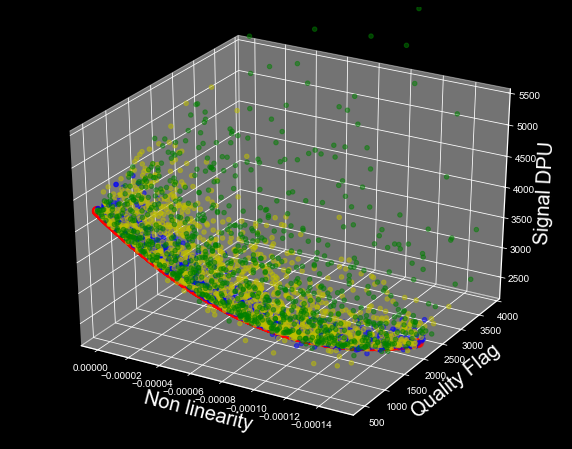

In [13]:
ch = np.transpose(chain)
plt.style.use('dark_background')

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

u = (ch[1]==0)
ax.scatter(ch[0][u],ch[4][u],ch[5][u], c='R',s=80,label='no RTN')

u = (ch[1]==1)
ax.scatter(ch[0][u],ch[4][u],ch[5][u], c='G',label='RTN1',alpha=0.5)

u = (ch[1]==2)
ax.scatter(ch[0][u],ch[4][u],ch[5][u], c='B',label='RTN2',alpha=0.5)

u = (ch[1]==3)
ax.scatter(ch[0][u],ch[4][u],ch[5][u], c='Y',label='RTN3',alpha=0.5)

#ax.set_zlim([-0.00012,0.0000])
ax.set_ylim([300,4000])
ax.set_zlim([2200,5500])

#plt.legend(loc=1,fontsize=20)
plt.gca().invert_xaxis()

ax.set_ylabel('Quality Flag',size=20)
ax.set_zlabel('Signal DPU',size=20)
ax.set_xlabel('Non linearity',size=20)
plt.savefig('plot_1.png')

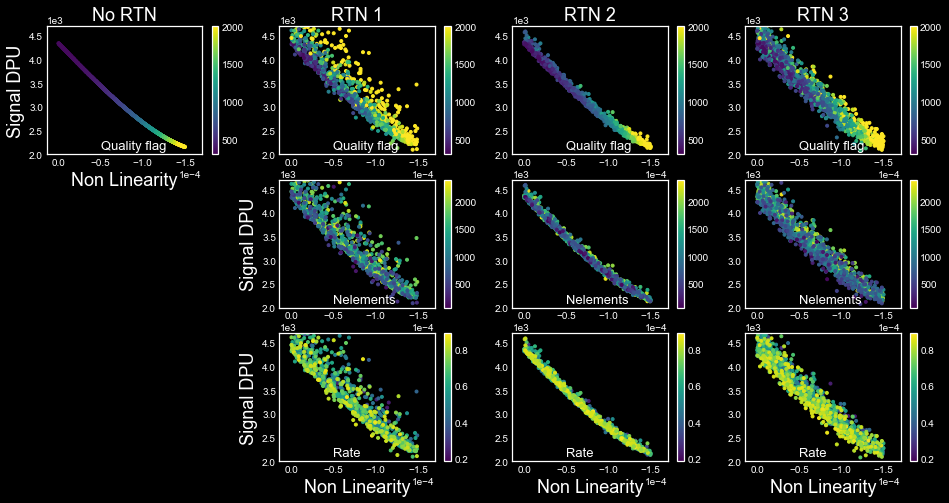

In [14]:
plt.figure(figsize=(16,8))
plt.subplot(3,4,1)
u = ch[1]==0
plt.scatter(ch[0][u],ch[5][u],c=ch[4][u],marker='.',cmap='viridis')
plt.clim(300,2000)
plt.colorbar()
plt.title('No RTN',size=18)
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.xlabel('Non Linearity',size=18)
plt.ylabel('Signal DPU',size=18)
plt.text(-0.00005,2100,'Quality flag',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()

plt.subplot(3,4,2)
u = ch[1]==1
plt.scatter(ch[0][u],ch[5][u],c=ch[4][u],marker='.',cmap='viridis')
plt.clim(300,2000)
plt.colorbar()
plt.title('RTN 1',size=18)
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.text(-0.00005,2100,'Quality flag',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,3)
u = ch[1]==2
plt.scatter(ch[0][u],ch[5][u],c=ch[4][u],marker='.',cmap='viridis')
plt.clim(300,2000)
plt.colorbar()
plt.title('RTN 2',size=18)
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.text(-0.00005,2100,'Quality flag',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,4)
u = ch[1]==3
plt.scatter(ch[0][u],ch[5][u],c=ch[4][u],marker='.',cmap='viridis')
plt.clim(300,2000)
plt.colorbar()
plt.title('RTN 3',size=18)
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.text(-0.00005,2100,'Quality flag',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,6)
u = ch[1]==1
plt.scatter(ch[0][u],ch[5][u],c=ch[2][u],marker='.',cmap='viridis')
plt.clim(np.min(ch[2]),np.max(ch[2]))
plt.colorbar()
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.text(-0.00005,2100,'Nelements',size=13)
plt.ylabel('Signal DPU',size=18)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,7)
u = ch[1]==2
plt.scatter(ch[0][u],ch[5][u],c=ch[2][u],marker='.',cmap='viridis')
plt.clim(np.min(ch[2]),np.max(ch[2]))
plt.colorbar()
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.text(-0.00005,2100,'Nelements',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,8)
u = ch[1]==3
plt.scatter(ch[0][u],ch[5][u],c=ch[2][u],marker='.',cmap='viridis')
plt.clim(np.min(ch[2]),np.max(ch[2]))
plt.colorbar()
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.text(-0.00005,2100,'Nelements',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,10)
u = ch[1]==1
plt.scatter(ch[0][u],ch[5][u],c=ch[3][u],marker='.',cmap='viridis')
plt.clim(np.min(ch[3]),np.max(ch[3]))
plt.colorbar()
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.xlabel('Non Linearity',size=18)
plt.ylabel('Signal DPU',size=18)
plt.text(-0.00005,2100,'Rate',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,11)
u = ch[1]==2
plt.scatter(ch[0][u],ch[5][u],c=ch[3][u],marker='.',cmap='viridis')
plt.clim(np.min(ch[3]),np.max(ch[3]))
plt.colorbar()
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.xlabel('Non Linearity',size=18)
plt.text(-0.00005,2100,'Rate',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


plt.subplot(3,4,12)
u = ch[1]==3
plt.scatter(ch[0][u],ch[5][u],c=ch[3][u],marker='.',cmap='viridis')
plt.clim(np.min(ch[3]),np.max(ch[3]))
plt.colorbar()
plt.xlim([-0.00017,0.000014])
plt.ylim([2000,4700])
plt.xlabel('Non Linearity',size=18)
plt.text(-0.00005,2100,'Rate',size=13)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.gca().invert_xaxis()


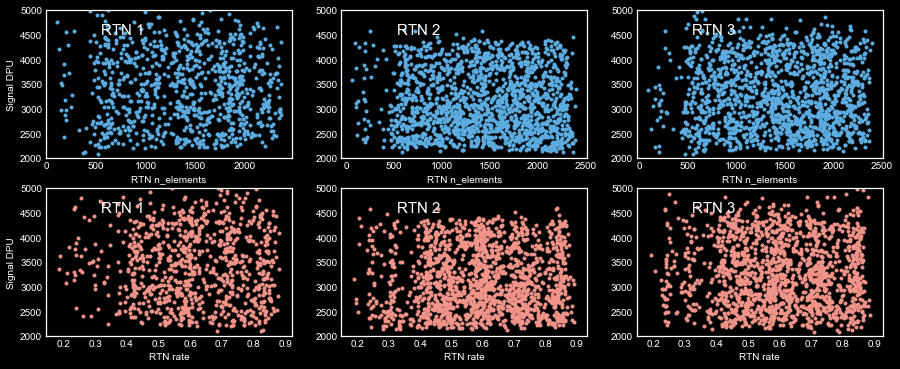

In [63]:

plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
u = ch[1]==1
plt.scatter(ch[2][u],ch[5][u],marker='.',label='RTN 1',c='#5DADE2')
plt.xlabel('RTN n_elements')
plt.ylabel('Signal DPU')
plt.ylim([2000,5000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,2)
u = ch[1]==2
plt.scatter(ch[2][u],ch[5][u],marker='.',label='RTN 2',c='#5DADE2')
plt.xlabel('RTN n_elements')
plt.ylim([2000,5000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,3)
u = ch[1]==3
plt.scatter(ch[2][u],ch[5][u],marker='.',label='RTN 3',c='#5DADE2')
plt.xlabel('RTN n_elements')
plt.ylim([2000,5000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,4)
u = ch[1]==1
plt.scatter(ch[3][u],ch[5][u],marker='.',label='RTN 1',c='#F1948A')
plt.xlabel('RTN rate')
plt.ylabel('Signal DPU')
plt.ylim([2000,5000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,5)
u = ch[1]==2
plt.scatter(ch[3][u],ch[5][u],marker='.',label='RTN 2',c='#F1948A')
plt.xlabel('RTN rate')
plt.ylim([2000,5000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,6)
u = ch[1]==3
plt.scatter(ch[3][u],ch[5][u],marker='.',label='RTN 3',c='#F1948A')
plt.xlabel('RTN rate')
plt.ylim([2000,5000])
plt.legend(loc=2,fontsize=15)


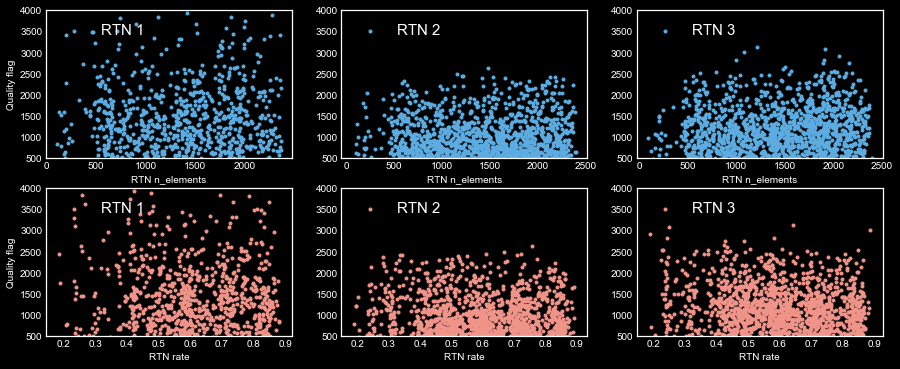

In [66]:

plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
u = ch[1]==1
plt.scatter(ch[2][u],ch[4][u],marker='.',label='RTN 1',c='#5DADE2')
plt.xlabel('RTN n_elements')
plt.ylabel('Quality flag')
plt.ylim([500,4000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,2)
u = ch[1]==2
plt.scatter(ch[2][u],ch[4][u],marker='.',label='RTN 2',c='#5DADE2')
plt.xlabel('RTN n_elements')
plt.ylim([500,4000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,3)
u = ch[1]==3
plt.scatter(ch[2][u],ch[4][u],marker='.',label='RTN 3',c='#5DADE2')
plt.xlabel('RTN n_elements')
plt.ylim([500,4000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,4)
u = ch[1]==1
plt.scatter(ch[3][u],ch[4][u],marker='.',label='RTN 1',c='#F1948A')
plt.xlabel('RTN rate')
plt.ylabel('Quality flag')
plt.ylim([500,4000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,5)
u = ch[1]==2
plt.scatter(ch[3][u],ch[4][u],marker='.',label='RTN 2',c='#F1948A')
plt.xlabel('RTN rate')
plt.ylim([500,4000])
plt.legend(loc=2,fontsize=15)

plt.subplot(2,3,6)
u = ch[1]==3
plt.scatter(ch[3][u],ch[4][u],marker='.',label='RTN 3',c='#F1948A')
plt.xlabel('RTN rate')
plt.ylim([500,4000])
plt.legend(loc=2,fontsize=15)


In [22]:
## Instantiate a noise generator object for NIRSpec H2RGs. You
# can set verbose=True if you want to see diagnostic information. This
# will take about 20 seconds to execute on a modern laptop computer.
ng_h2rg = ng.HXRGNoise(verbose=False, naxis3 = 2)
#ng_h4rg = ng.HXRGNoise(naxis1=4096, naxis2=4096, n_out=32, nroh=8, verbose=False)


# Use parameters that generate noise similar to JWST NIRSpec
rd_noise=4.   # White read noise per integration
pedestal=4.   # DC pedestal drift rms
c_pink=3.     # Correlated pink noise
u_pink=1.     # Uncorrelated pink noise
acn=.5        # Correlated ACN
pca0_amp=.2   # Amplitude of PCA zero "picture frame" noise

# Do it
my_hdu = ng_h2rg.mknoise('ex_2.1.1.fits', rd_noise=rd_noise, pedestal=pedestal,
                c_pink=c_pink, u_pink=u_pink, acn=acn, pca0_amp=pca0_amp)

In [4]:
import astropy.io.fits as fits


# Open the result of Ex. 2.1.1
hdulist = fits.open('ex_2.1.1.fits')

# Add Poisson noise to the data
d = hdulist[0].data 

print(d.shape)

import astropy.io.fits as fits
# Setup
i_dark = 0.005# e-/s/pix
t = 934.# s

# Open the result of Ex. 2.1.1
hdulist = fits.open('ex_2.1.1.fits')

# Add Poisson noise to the data
d = hdulist[0].data + np.random.poisson(i_dark*t, np.shape(hdulist[0].data))

# Write result
hduout = fits.PrimaryHDU(d)
hduout.writeto('ex_2.1.1b.fits', clobber=True)

# Clean up
hdulist.close()

(2, 2048, 2048)
